# EECE 550 HW 2 Question 8: Full Bridge Forward Converter
Shelby Quiring, 10157162, March 15th 2024

In [25]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import sympy as sp
import control as ctr
import control.matlab as ctrm

In [26]:
# Inputs
Vi = 170  # V
Vo = 5  # V
Io = 75  # A
delta_Vo_percent = 0.02  # %pp
delta_Il_percent = 0.03  # %pp
Fsw = 150e3  # Hz, switching frequency
t_dead = 300e-9  # seconds

# Derived quantities
R = Vo / Io

# Calculate duty cycle
Ts = 1/Fsw
To = Ts / 2 - t_dead

Dp = To / Ts  
Ds = 2*Dp

# Calculate transformer turns ratio
N = Vo / Vi / (2*Dp)

IL = Io
Vc = Vo

# Component values
delta_il_pp = delta_Il_percent * Io / (1-Dp)
delta_vo_pp = delta_Vo_percent * Vo
C = Vo * Dp / (Fsw * R * delta_vo_pp)
L = Vi * Dp / (Fsw * delta_il_pp)

print(f'Duty Cycle Dp: {Dp*100:.1f} %')
print(f'Duty Cycle Ds: {Ds*100:.1f} %')
print(f'Transformer Ratio N: {N:.3f} %')
print(f'Capacitor: {C * 1e6:.3f} uF')
print(f'Inductor: {L * 1e6:.3f} uH\n')
print(f'Load Resistor: {R:.3f} Ohms\n')

# Define matricies
gamma = np.diag([L, C])

alpha = np.array([
    [ 0,   -1   ],
    [ 1,   -1/R ]
])

# Only duty cycle input
beta = np.array([
    [ 2*N*Vi ],
    [   0    ]
])

A = np.linalg.inv(gamma) @ alpha
B = np.linalg.inv(gamma) @ beta
C_ = np.array([0, 1])
D_ = np.array([0])

print(f'A: \n{A}\n')
print(f'B: \n{B}\n')

# Check controllability
ctr_rank = np.linalg.matrix_rank(ctr.ctrb(A, B))
print(f'Controllability Rank: {ctr_rank}\n')

# Make state space model
sys = ctr.ss(A, B, C_, D_)
print('Linearized Model:')
display(sys)

# Check stability
e, V = sci.linalg.eig(A)
print('\nEigvals of A Matrix:')
print(e)

Duty Cycle Dp: 45.5 %
Duty Cycle Ds: 91.0 %
Transformer Ratio N: 0.032 %
Capacitor: 2275.000 uF
Inductor: 124.906 uH

Load Resistor: 0.067 Ohms

A: 
[[    0.         -8006.02527532]
 [  439.56043956 -6593.40659341]]

B: 
[[87978.29972877]
 [    0.        ]]

Controllability Rank: 2

Linearized Model:


<LinearIOSystem:sys[191]:['u[0]']->['y[0]']>


Eigvals of A Matrix:
[ -585.77713811+0.j -6007.6294553 +0.j]


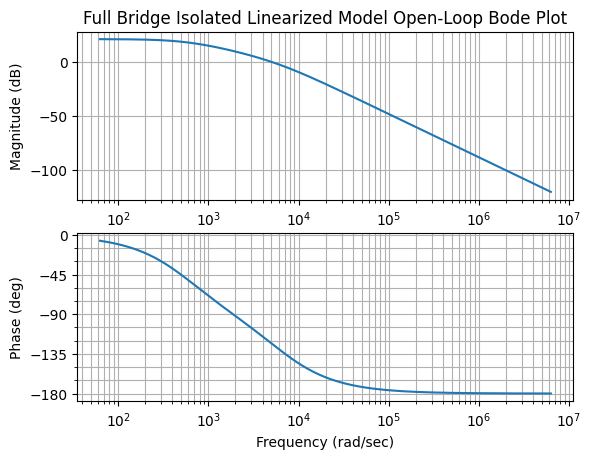

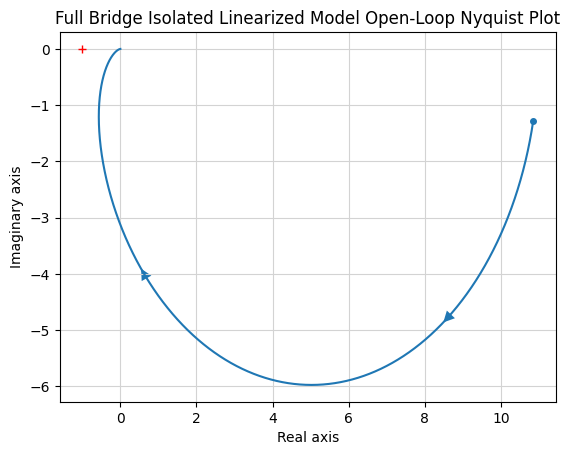

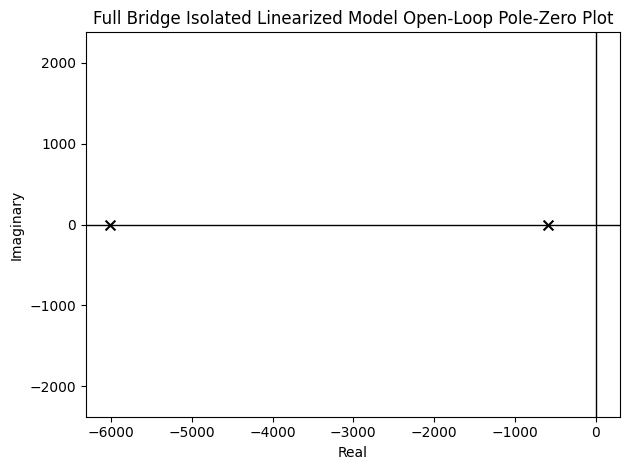

In [27]:
# Look at the frequency response and other control plots
fvec = np.logspace(1, 6, 10000)
omegavec = fvec * 2 * np.pi

fig = plt.figure()
ctr.bode_plot(sys, omegavec)
fig.axes[0].set_title('Full Bridge Isolated Linearized Model Open-Loop Bode Plot')

fig, ax = plt.subplots()
ctr.nyquist(sys, omegavec, primary_style=['-', '-'], mirror_style=False)
ax.set_title('Full Bridge Isolated Linearized Model Open-Loop Nyquist Plot')

fig = plt.figure() 
ctr.pzmap(sys)
plt.title('Full Bridge Isolated Linearized Model Open-Loop Pole-Zero Plot')
fig.tight_layout()

Coefficient Arrays:

Num: [[array([0.73260073])]]
Den: [[array([1.89440654e-08, 1.24905926e-04, 6.66666667e-02])]]

Transfer Function:



TransferFunction(array([0.73260073]), array([1.89440654e-08, 1.24905926e-04, 6.66666667e-02]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


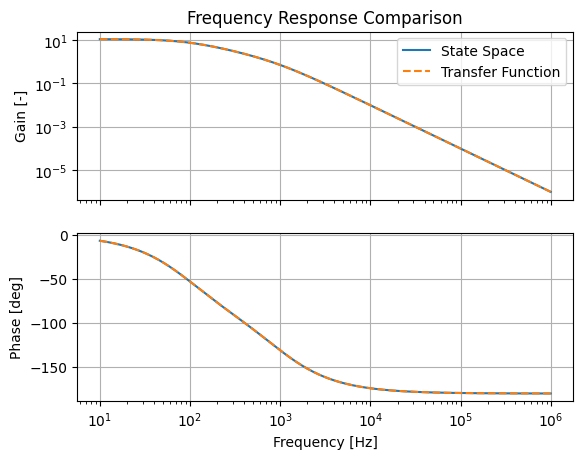

In [28]:
# Get the transfer function and compare to the state space model

# Create a transfer function object
s = ctr.tf('s')
H = 2*N*Vi*R / (R + L*s + L*C*R*s**2)

print('Coefficient Arrays:\n')
print(f'Num: {H.num}')
print(f'Den: {H.den}')

print('\nTransfer Function:\n')
display(H)


# Plot the bode plot using this transfer function and compare to the state space model
fig, ax = plt.subplots(2, 1, sharex=True)
mss, pss, _ = ctrm.freqresp(sys, omegavec)
mtf, ptf, _ = ctrm.freqresp(H, omegavec)
ax[0].loglog(fvec, mss, label='State Space')
ax[0].loglog(fvec, mtf, '--', label='Transfer Function')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_title('Frequency Response Comparison')
ax[0].set_ylabel('Gain [-]')

ax[1].semilogx(fvec, np.unwrap(pss) * 180 / np.pi, label='State Space')
ax[1].semilogx(fvec, np.unwrap(ptf) * 180 / np.pi, '--', label='Transfer Function')
ax[1].grid('enable')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')

# Save the figure
plt.savefig(f'figs/bridge_freqresp.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


4 states have been removed from the model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


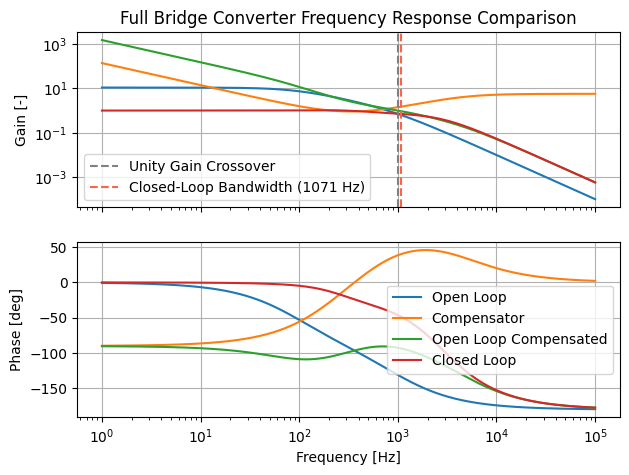

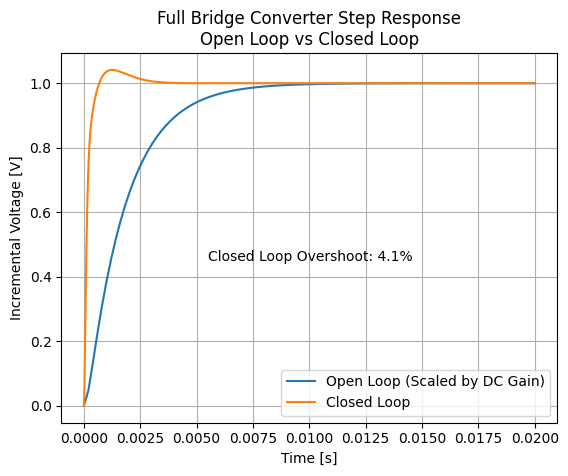

In [29]:
### Compensator design
# Set up s variable
s = ctr.tf([1, 0], 1)

#### Good
# Define desired unity gain crossover
wc = 2*np.pi*1000  # rad/s 
phi_comp = 65 * np.pi/180

# Calculate other lead compensator values
alpha_c = (1 + np.sin(phi_comp)) / (1 - np.sin(phi_comp))
tau = 1 / (wc * np.sqrt(alpha_c))

# Calulate integrator gain and lowpass filter cutoff
Ki = wc / 2

# Define sub-controllers
integral = (Ki + s) / s
lead_comp = (alpha_c*tau*s + 1) / (tau*s + 1)

# Define preliminary compensator and preliminary new loop return ratio
CT_1 = integral * lead_comp
LR_1 = CT_1 * H  # Compen/sated loop return ratio

# Calculate proportional gain required to achieve the desired crossover
Kp = 1 / ctr.freqresp(LR_1, wc)[0][0] 

# Finally, define full controller and full compensated loop return
CT = Kp * CT_1
LR = CT * H # Fully compensated loop return ratio

# Define the closed loop system
Gcl = LR / (1 + LR)


# Plot the frequency response
fvec = np.logspace(0, 5, 10000)
omegavec = fvec * 2 * np.pi


fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
mol, pol, _ = ctrm.freqresp(H, omegavec)
mc, pc, _ = ctrm.freqresp(CT, omegavec)
molc, polc, _ = ctrm.freqresp(LR, omegavec)
mcl, pcl, _ = ctrm.freqresp(Gcl, omegavec)

bdw = ctr.bandwidth(ctr.minreal(Gcl))

ax[0].loglog(fvec, mol)#, label='Open Loop')
ax[0].loglog(fvec, mc)#, label='Compensator')
ax[0].loglog(fvec, molc)#, label='Open Loop Compensated')
ax[0].loglog(fvec, mcl)#, label='Closed Loop')
ax[0].axvline(wc / (2*np.pi), color='0.5', linestyle='--', label='Unity Gain Crossover')
ax[0].axvline(bdw / (2*np.pi), color='tomato', linestyle='--', label=f'Closed-Loop Bandwidth ({bdw/ (2*np.pi):.0f} Hz)')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_title('Full Bridge Converter Frequency Response Comparison')
ax[0].set_ylabel('Gain [-]')
ax[1].semilogx(fvec, np.unwrap(pol) * 180 / np.pi, label='Open Loop')
ax[1].semilogx(fvec, np.unwrap(pc) * 180 / np.pi, label='Compensator')
ax[1].semilogx(fvec, np.unwrap(polc) * 180 / np.pi, label='Open Loop Compensated')
ax[1].semilogx(fvec, np.unwrap(pcl) * 180 / np.pi, label='Closed Loop')
ax[1].grid('enable')
ax[1].legend()
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')

# Save the figure
plt.savefig(f'figs/bridge_controller.eps', format='eps')

# Plot the step response
fig, ax = plt.subplots()
yol, tol = ctrm.step(H, 0.02)
ycl, tcl = ctrm.step(Gcl, 0.02)
# ycla, tcla = ctrm.step(Gcla, 0.05)
ax.plot(tol, yol / ctrm.dcgain(H), label='Open Loop (Scaled by DC Gain)')
ax.plot(tcl, ycl, label='Closed Loop ')
# ax.plot(tcla, ycla, label='Closed Loop Alt')
ax.text(0.0055, 0.45, f'Closed Loop Overshoot: {100*(np.max(ycl) - 1):.1f}%')
ax.grid('enable')
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Incremental Voltage [V]')
ax.set_title('Full Bridge Converter Step Response\nOpen Loop vs Closed Loop')

# Save the figure
plt.savefig(f'figs/bridge_steptest.eps', format='eps')

Controller State Space Model:


StateSpace(array([[-2.83416174e+04, -0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00]]), array([[1.],
       [0.]]), array([[ -136249.69581836, 25044620.76510367]]), array([[5.72307558]]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


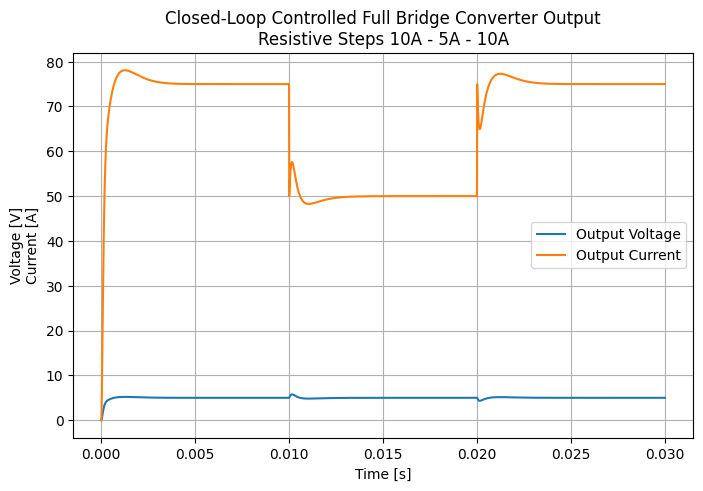

In [30]:
# Resistive step responses

# Define new systems for the closed-loop simulations
gamma = np.diag([L, C])

alpha_10 = np.array([
    [ 0,   -1   ],
    [ 1,   -1/R ]
])

alpha_5 = np.array([
    [ 0,   -1   ],
    [ 1,   -1/(1.5*R) ]
])

# Only duty cycle input
beta = np.array([
    [ 2*N*Vi ],
    [   0    ]
])

A_10 = np.linalg.inv(gamma) @ alpha_10
A_5 = np.linalg.inv(gamma) @ alpha_5
B_ = np.linalg.inv(gamma) @ beta
C_ = np.array([0, 1])
D_ = np.array([0])

# Get state space model for controller
CT_ss = ctr.tf2ss(CT)
print('Controller State Space Model:')
display(CT_ss)


Ac = CT_ss.A
Bc = CT_ss.B
Cc = CT_ss.C
Dc = CT_ss.D

row_ol, col_ol = np.shape(A_10)
row_c, col_c = np.shape(Ac)

# Construct augmented controlled matricies
Baug = np.block([
    [ B_ @ Dc ],
    [   Bc    ]
])

Caug = np.block([ C_, np.zeros((1, col_c)) ])

Daug = 0

Aaug_10 = np.block([
    [         A_10,              B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug

Aaug_5 = np.block([
    [         A_5,               B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug


# Make state space model
sys_aug_10 = ctr.ss(Aaug_10, Baug, Caug, Daug)
sys_aug_5 = ctr.ss(Aaug_5, Baug, Caug, Daug)

sys_ol_10 = ctr.ss(A_10, B_, C_, D_)
sys_ol_5 = ctr.ss(A_5, B_, C_, D_)


# Define input vectors
dt = 1e-5
Tmax = 0.01
time_segment = np.arange(0, Tmax, dt)
u_segment = np.ones_like(time_segment) * Vo
u_segment_ol = np.ones_like(time_segment) * Vo / ctr.dcgain(sys_ol_10)
y0 = 0

# Simulate nominal operation
yout_1, tout_1, xout_1 = ctrm.lsim(sys_aug_10, u_segment, time_segment) 
yout_ol_1, tout_ol_1, xout_ol_1 = ctrm.lsim(sys_ol_10, u_segment_ol, time_segment) 

# Simulate current step down
yout_2, tout_2, xout_2 = ctrm.lsim(sys_aug_5, u_segment, time_segment, xout_1[-1])
yout_ol_2, tout_ol_2, xout_ol_2 = ctrm.lsim(sys_ol_5, u_segment_ol, time_segment, xout_ol_1[-1]) 

# Simulate current step up
yout_3, tout_3, xout_3 = ctrm.lsim(sys_aug_10, u_segment, time_segment, xout_2[-1]) 
yout_ol_3, tout_ol_3, xout_ol_3 = ctrm.lsim(sys_ol_10, u_segment_ol, time_segment, xout_ol_2[-1]) 

# Plot all the results
time_all = np.array([*time_segment, *(time_segment + Tmax), *(time_segment + Tmax*2)])

yout_all = np.array([*yout_1, *yout_2, *yout_3])
xout_all = np.block([xout_1.T, xout_2.T, xout_3.T])
current_all = np.array([*yout_1 * (-alpha_10[-1, -1]), *yout_2 * (-alpha_5[-1, -1]), *yout_3 * (-alpha_10[-1, -1])])

yout_ol_all = np.array([*yout_ol_1, *yout_ol_2, *yout_ol_3])
xout_ol_all = np.block([xout_ol_1.T, xout_ol_2.T, xout_ol_3.T])
current_ol_all = np.array([*yout_ol_1 * (-alpha_10[-1, -1]), *yout_ol_2 * (-alpha_5[-1, -1]), *yout_ol_3 * (-alpha_10[-1, -1])])


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time_all, yout_all, label='Output Voltage')
ax.plot(time_all, current_all, label='Output Current')
ax.grid('enable')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]\nCurrent [A]')
ax.set_title('Closed-Loop Controlled Full Bridge Converter Output\nResistive Steps 10A - 5A - 10A')
ax.legend()

# Save the figure
plt.savefig(f'figs/bridge_steps.eps', format='eps')